**Table of contents**<a id='toc0_'></a>    
- 1. [Preprocessing](#toc1_)    
- 2. [Intro: A surprising plot!](#toc2_)    
  - 2.1. [Loading the Dataset](#toc2_1_)    
  - 2.2. [A Surprising Plot of Average Ratings Per Month Over Many Years](#toc2_2_)    
- 3. [Verifying Year-to-Year Seasonality: Are the Patterns Consistent?](#toc3_)    
  - 3.1. [Seasonality Metrics](#toc3_1_)    
- 4. [Pinpointing the Source: Seasonal Versus Year-Round Beers](#toc4_)    
  - 4.1. [Seasonality Score for Beer Ratings](#toc4_1_)    
  - 4.2. [Seasonality in the Popularity of Beer Styles](#toc4_2_)    
  - 4.3. [Popularity and Rating of Selected Beer Styles](#toc4_3_)    
- 5. [3 Weather Influence by State](#toc5_)    
  - 5.1. [climatezone per country / state](#toc5_1_)    
  - 5.2. [Extracting weather data from excel files](#toc5_2_)    
  - 5.3. [Data Analysis](#toc5_3_)    
  - 5.4. [Archive - World Climate Zones](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as py

from statsmodels.tsa.seasonal import STL

py.init_notebook_mode(connected=True)

sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from src.utils.locationHelper import LocationHelper
from src.utils.preProcessingHelper import PreProcessRatings
import src.utils.preProcessingHelper as preProcessingHelper
from src.utils.jeanneHelper import JeanneHelper
import src.utils.seasonalityMetrics as sm 

helper = JeanneHelper()

from pandas.api.types import CategoricalDtype

import scipy.stats as stats
from scipy.stats import  kruskal, anderson, shapiro
import random

import src.utils.USClimateAndWeatherHelper as WaH
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(42)

Note: The graphics that we created with plotly won't show on git. We saved all of them in illustrations in the defined folder.

# 1. <a id='toc1_'></a>[Preprocessing](#toc0_)
### Which data should we use for our investigation?

For this project, we used BeerAdvocate data, focusing on US-based reviews from 2002 to 2017 to ensure we had enough consistent data. 
We looked at key details a rating scores, timestamps, user locations, and beer styles. 

For the preprocessing we've written a [preProcessingHelper.py](src/utils/preProcessingHelper.py). We have a jupyter notebook [preProcessing.ipynb](test/preProcessing.ipynb) which shows our workflow to eventually get the preProcessingHelper.py


Additionally we've written a [locationHelper.py](src/utils/locationHelper.py), which adds the country and state codes to the reviews. For the part of the analysis that needs a corresponding location to the review, we assume that the location of the user that wrote the review is most likely the location where the review was written. If there is still time after our main tasks, this is something we could investigate further.

In [ ]:
pp = PreProcessRatings(platform="BeerAdvocate")
df = pp.get_dataframe(dataset="both", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style", "beer_name", "beer_id"])
df.to_csv("src/data/beerAdvocateRatingsBothDatasets.csv")

In [4]:
both_df = pd.read_csv("src/data/beerAdvocateRatingsBothDatasets.csv", index_col=0) # dataset containing reviews and ratings

In [9]:
both_df.head()

,rating,is_review,country_name,country_code3,state,date_object,month,year,style,beer_name,beer_id
0,2.88,True,United States,USA,Washington,2015-08-20 12:00:00,8,2015,Euro Pale Lager,Régab,142544
1,3.67,True,United States,USA,New York,2009-02-20 12:00:00,2,2009,English Pale Ale,Barelegs Brew,19590
5,3.25,False,United States,USA,Kansas,2014-12-01 12:00:00,12,2014,English Pale Ale,Legbiter,19827
6,3.50,False,United States,USA,New Jersey,2014-05-29 12:00:00,5,2014,English Pale Ale,Legbiter,19827
7,3.50,False,United States,USA,North Carolina,2014-02-26 12:00:00,2,2014,English Pale Ale,Legbiter,19827


To make things easier and more robust to changes differences of rating systems that are eventually reflected in the rating, we took the decision to do our investigation for only one platform (and maybe do it for the other platform depending on how much time is left in the end of the project). As BeerAdvocate has more data compared to RateBeer and has more fine grained data, we concluded to go for BeerAdvocate in the US. BeerAdvocates data mainly stems from the US, which we can see on the map down below. Aditionally, we have a further partitioning in the states

In [6]:
ratings_count = both_df.groupby("country_code3").agg(nr_ratings=("country_code3", "count")).reset_index()
ratings_count["nr_ratings_log"] = np.log2(ratings_count["nr_ratings"]).replace(-np.inf, 0)

country_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
map = folium.Map(location=[10, 0], zoom_start=1.5)
cp = folium.Choropleth(geo_data=country_geo,
            data=ratings_count,
            columns=['country_code3', 'nr_ratings_log'],
            key_on='feature.id',
            fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
            legend_name="Nr. of ratings (log2 scale)",
            highlight=True

        ).add_to(map)

for s in cp.geojson.data['features']:
      if s['id'] in ratings_count['country_code3'].values:
            s['properties']['nr_ratings'] = (ratings_count[ratings_count["country_code3"] == s['id']]["nr_ratings"]).values[0].astype(str)
      else:
            s['properties']['nr_ratings'] = "0"
      
folium.GeoJsonTooltip(['name', "nr_ratings"]).add_to(cp.geojson)
folium.LayerControl().add_to(map)

map.save("illustrations/Tim/nr_ratings_BeerAdvocate.html")

map

In [ ]:
# reduce our dataframe to data from US
both_df = both_df[both_df["country_code3"] == "USA"]

### Can we find special behaviour for some year?

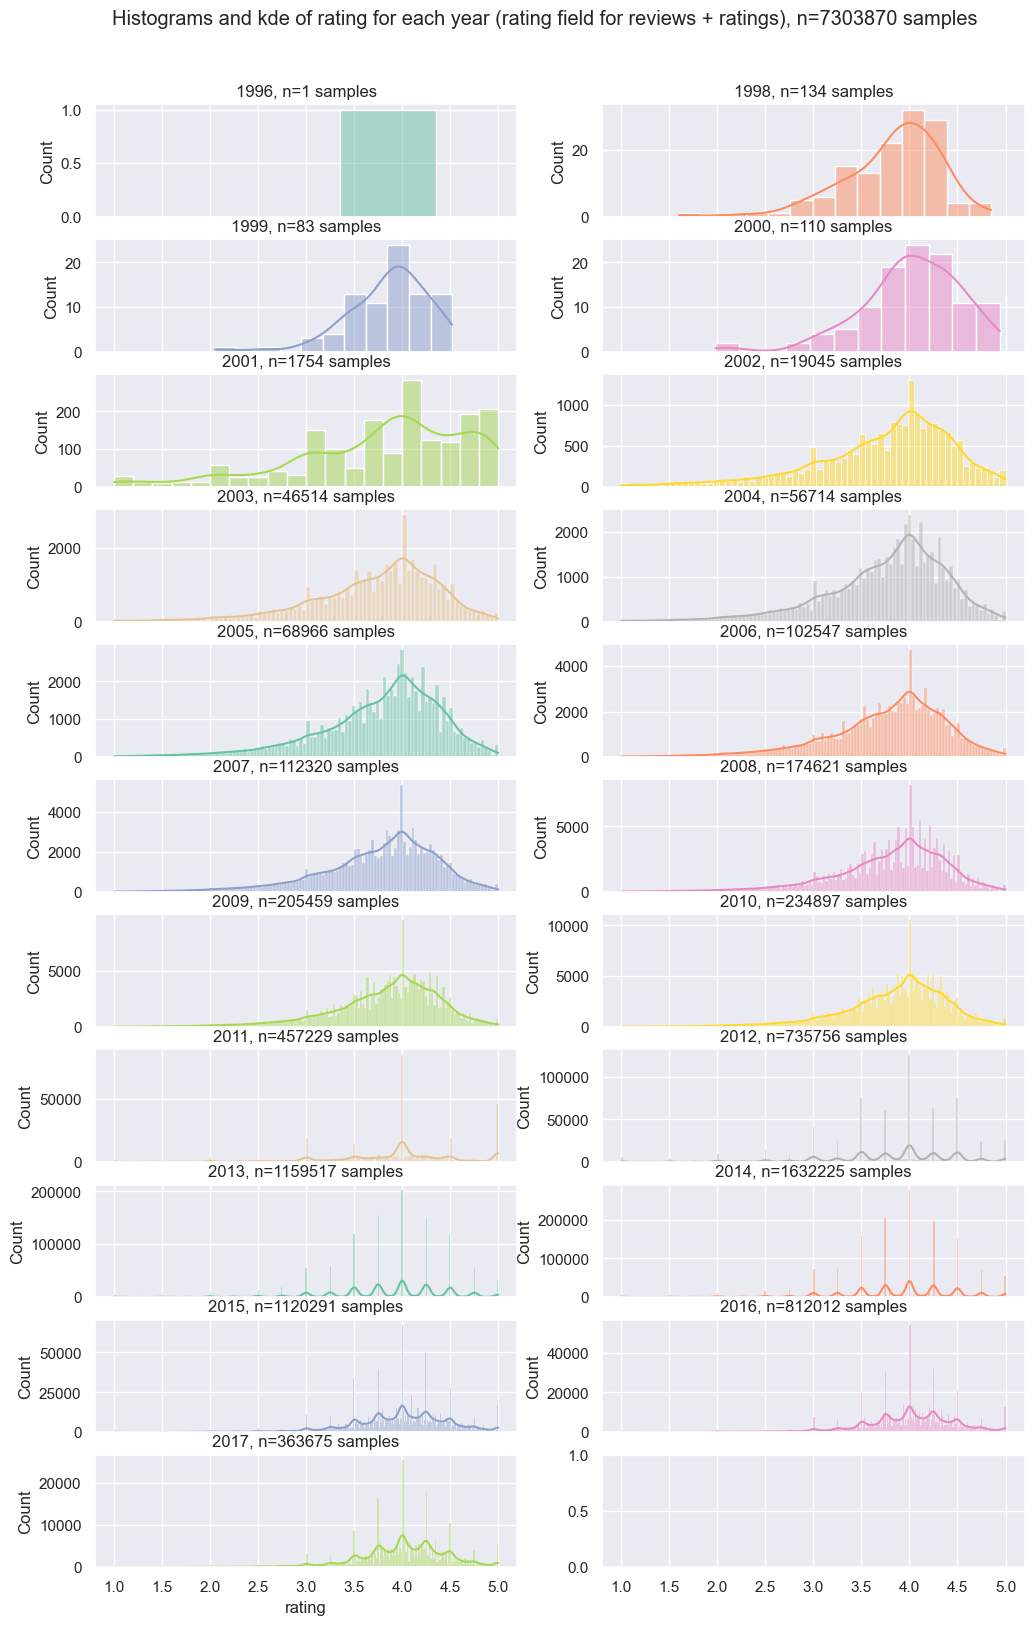

In [4]:
years = np.sort(both_df["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 19), sharex=True)
ax = ax.flatten()
fig.suptitle(f"Histograms and kde of rating for each year (rating field for reviews + ratings), n={both_df.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = both_df[both_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i], color=palette[i%len(palette)])
    h.set_title(f'{int(year)}, n={year_df.shape[0]} samples')

In [37]:
# same with plotly
fig = px.histogram(both_df, x="rating", color="is_review", barmode="overlay", facet_row="year",
                   labels={"is_review": "Review", "rating": "Nr Ratings/Reviews"},
                   title="Nr of Reviews and Nr of Ratings per year"
                   )
fig.write_html("illustrations/Tim/histReviewsAndRatingsPerYear.html")

In [36]:

df = both_df.groupby(["year", "is_review"])["rating"].agg("count").reset_index()
fig = px.bar(df, x="year", y="rating", color="is_review", barmode="overlay",
                   labels={"is_review": "Review", "rating": "Nr Ratings/Reviews"},
                   title="Nr of Reviews and Nr of Ratings per year"
                   )

# fig.update_traces(opacity=0.5, marker_color="red", selector=dict(name="True")) 
# fig.update_traces(opacity=1, marker_color="blue", selector=dict(name="False"))
fig.write_html("illustrations/Tim/histNrReviewsVsRatings.html")
fig.show()


Looking at the plots we see that starting from 2002 the number of ratings start to rise and is more similar to the other years. We conclude that most likely the rating system changed as well. To not let old data screw our results, we get rid of the data before 2002.

In [5]:
both_df = both_df[both_df["year"] >= 2002]
reviews_df = both_df[both_df["is_review"]]
ratings_df = both_df[~both_df["is_review"]]

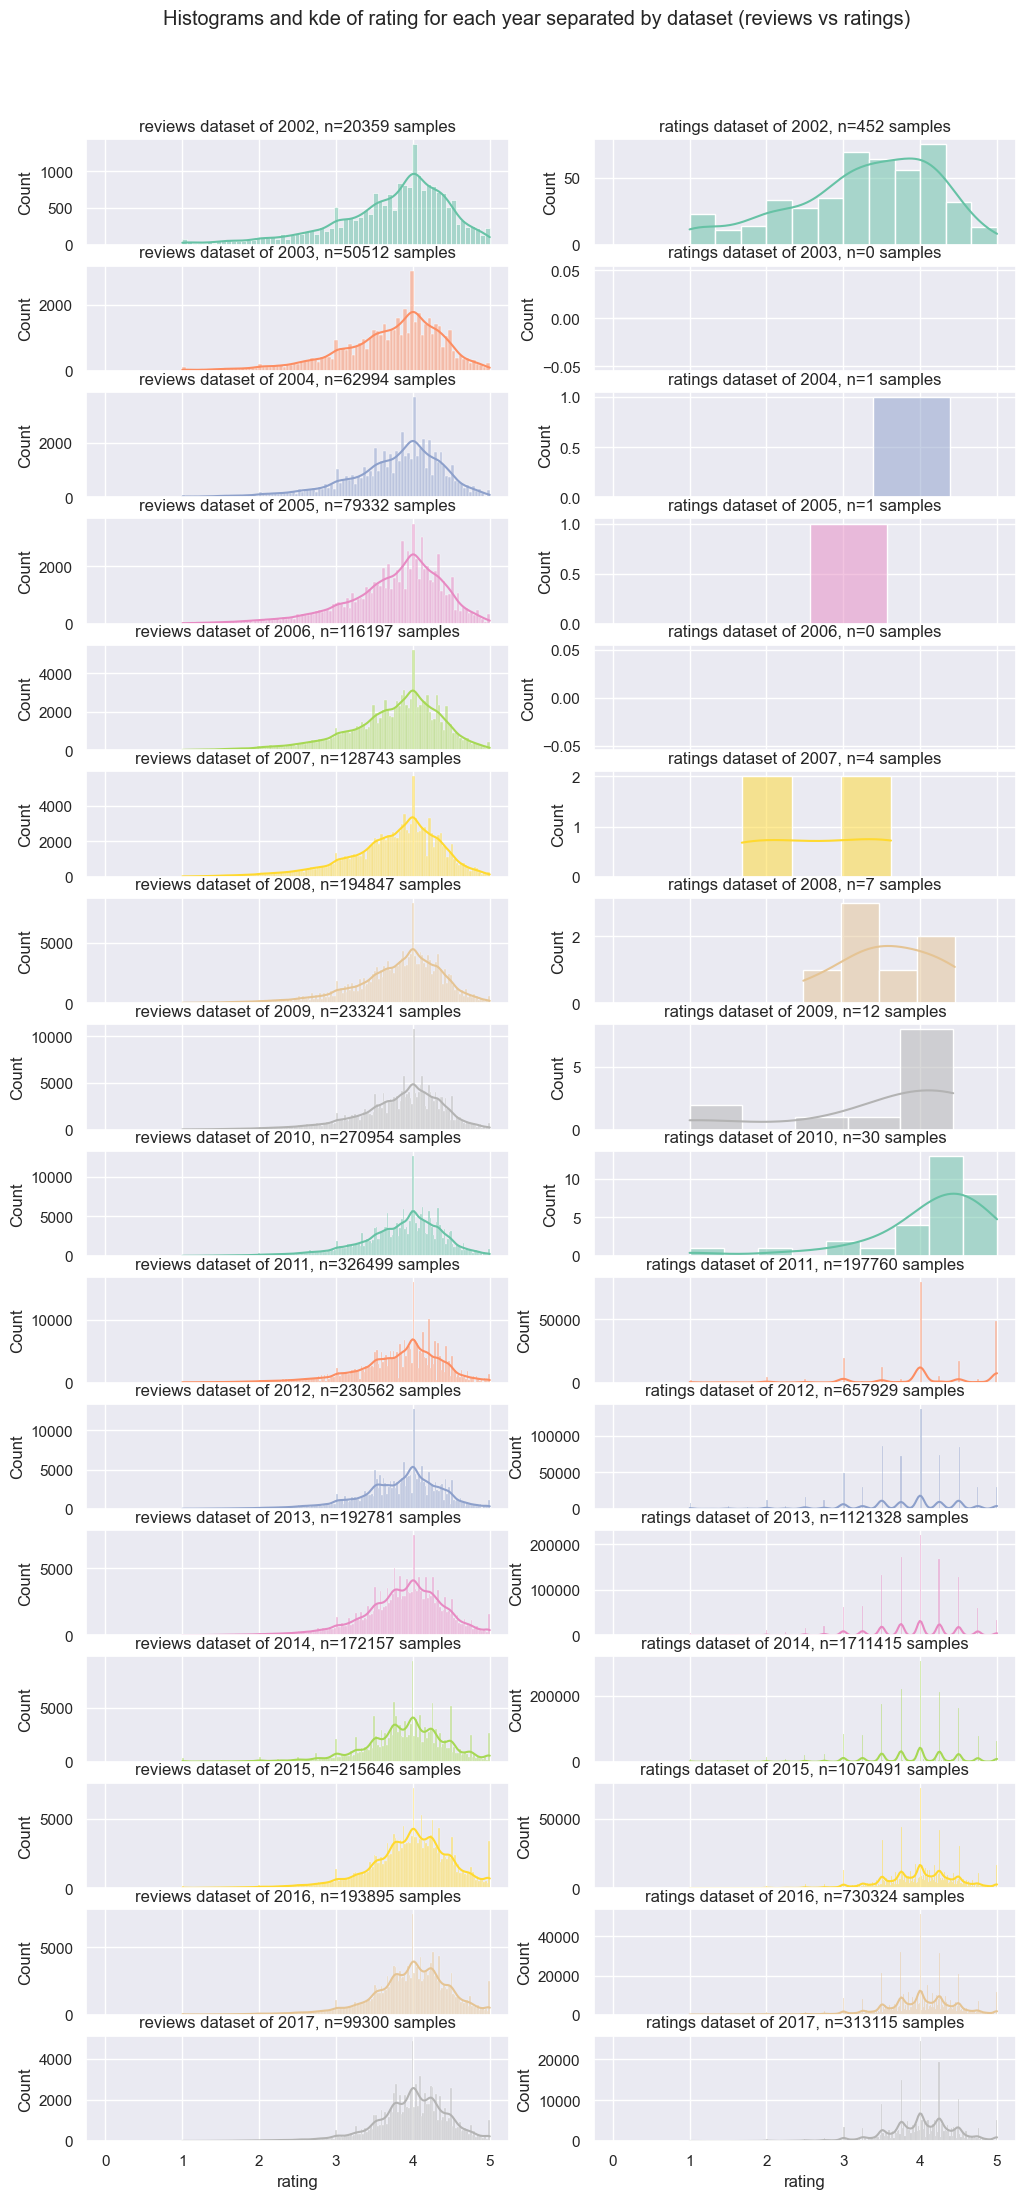

In [40]:
years = np.sort(reviews_df["year"].dropna().unique())
fig, ax = plt.subplots(int(len(years)), 2, figsize= (12, 26), sharex=True)

fig.suptitle(f"Histograms and kde of rating for each year separated by dataset (reviews vs ratings)", y=0.93)

# reviews
for i, year in enumerate(years):
    year_df = reviews_df[reviews_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i][0], color=palette[i%len(palette)])
    h.set_title(f'reviews dataset of {int(year)}, n={year_df.shape[0]} samples')

# reviews
for i, year in enumerate(years):
    year_df = ratings_df[ratings_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i][1], color=palette[i%len(palette)])
    h.set_title(f'ratings dataset of {int(year)}, n={year_df.shape[0]} samples')

Furthermore, there are two datasets: ratings and reviews. We conclude that these are two ways how people can record a beer review. Both datasets have a rating attribute $r \in [1, 5]$, which reflects the quality of a beer.
- In the reviews dataset, $r$ is calculated as a weighted mean over different attributes.
- In the rating dataset, $r$ is a continuous number (from 2011-2014, $r$ was discrete with steps of 0.25).

Until 2011, there were more reviews than ratings. From 2011 to 2017 there are a lot more ratings than reviews. We conclude to work with data from **the reviews dataset**. It's less data but, more importantly, it's more balanced over the years.

In [ ]:
# plot for reducement of the dataset
both_df = pd.read_csv("src/data/beerAdvocateRatingsBothDatasets.csv", index_col=0) # dataset containing reviews and ratings
lenArr = []
lenArr.append(len(both_df))

both_df = both_df[both_df["country_code3"] == "USA"]
lenArr.append(len(both_df))

reviews_df = both_df[both_df["is_review"]]
lenArr.append(len(reviews_df))

reviews_df = reviews_df[reviews_df["year"] >= 2002]
lenArr.append(len(reviews_df))


data = dict(
    number=lenArr,
    stage=["BeerAdvocate", "Only USA", "only Reviews", ">=2002"])
fig = px.funnel(data, x='number', y='stage', title= "Reduction in Size of our Dataset")

fig.write_html("illustrations/Tim/funnelSizeReductionDataset.html")
fig.show()

# 2. <a id='toc2_'></a>[Intro: A surprising plot!](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Loading the Dataset](#toc0_)

In [ ]:
ph = PreProcessRatings(platform="BeerAdvocate")
reviews_df = ph.get_dataframe(dataset="reviews", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style"])
reviews_df.to_csv("src/data/beerAdvocateReviews.csv", index=False)

In [ ]:
reviews_df = pd.read_csv("src/data/beerAdvocateReviews.csv") # dataset containing reviews
reviews_df = reviews_df[(reviews_df["year"] >= 2002) & (reviews_df["country_code3"] >= "USA")]


## 2.2. <a id='toc2_2_'></a>[A Surprising Plot of Average Ratings Per Month Over Many Years](#toc0_)

The following plot displays the average ratings for all beers across every month from multiple years, based on over two million ratings. 

For example, the value for month 6 represents the average rating for all June months between 2002 and 2017. 

This plot, referred to as the "Main Average Rating Plot," appears to show fluctuations in beer ratings throughout the year.

Text(0.5, 1.0, 'Avg rating in the US over the period 2002 - 2017 with 95% confidence interval, n=2240430')

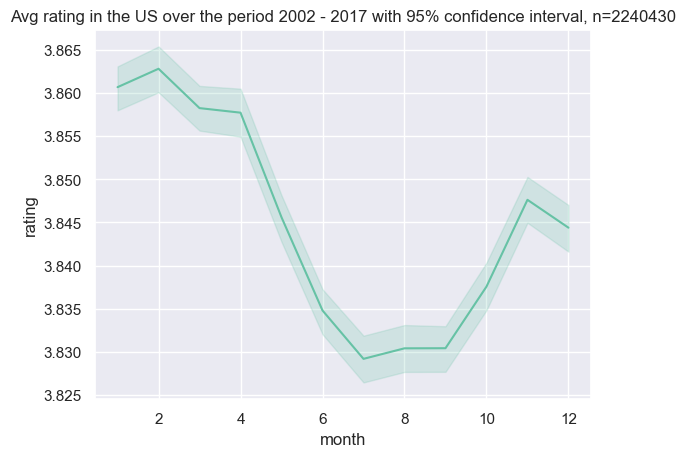

In [7]:
sns.lineplot(reviews_df, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating in the US over the period {reviews_df["year"].min()} - {reviews_df["year"].max()} with 95% confidence interval, n={reviews_df.shape[0]}')

But why could this be the case? In this project, our goal is to investigate the underlying reasons for this apparent seasonal behavior in beer ratings. 

Specifically, we seek to answer several key questions:
- Is this pattern driven by year-to-year effects or are these fluctuations simply random? 
- Is there a particular subset of beers responsible for these seasonal variations? 
- And could factors like climate or weather influence these rating trends?

Through careful analysis, we aim to uncover the reasons behind the observed seasonal behavior in beer ratings and provide a deeper understanding of the trends reflected in the Main Average Rating Plot.

Anderson-Darling test to check for normality for month 1:
AndersonResult(statistic=np.float64(2746.054774901422), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.8606827589862713), scale=np.float64(0.5972202352409599))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test to check for normality for month 2:
AndersonResult(statistic=np.float64(2506.722981902567), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.862817498203195), scale=np.float64(0.5954146412276019))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test to check for normality for month 3:
AndersonResult(statistic=np.float64(2674.223614056624), critical_values=array([0.576, 0.656, 0.

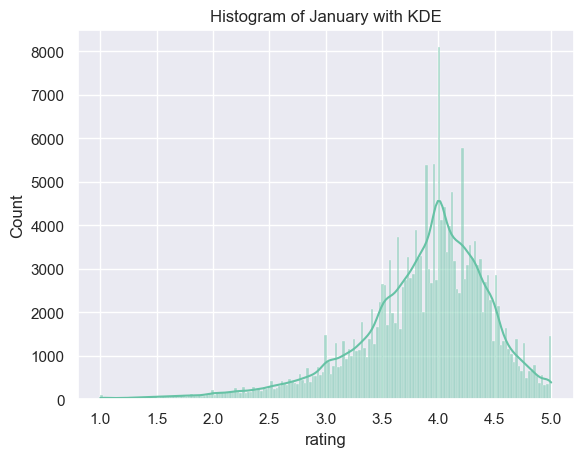

In [ ]:
monthly_ratings = get_rating_per_month(reviews_df)
h = sns.histplot(monthly_ratings[0], kde=True)
h.set_title("Histogram of January with KDE")
h.set_xlabel("rating")

for i, ratings in enumerate(monthly_ratings):
    print(f"Anderson-Darling test to check for normality for month {i+1}:")
    print(anderson(ratings, dist="norm"))
    print()

 We aim to determine if this variation is statistically significant. 

First, we test whether we can assume normality in the data.

 Given the large sample size, we chose the Anderson-Darling Test over the Shapiro-Wilk Test to assess normality. We can see that, for each month, the statistics exceeds the critical value by far (for each significance level). 
 
 Therefore we'll reject the null hypothesis and don't assume normality which is not surprising by looking at the histogram for the ratings of january. 

Our dependent variable is the rating of the beer and our indepenent variable is the month. We want to assess the differences between groups on a continuous measurement (rating) with only one, categorical independent variable (month). As we can't assume normality, we choose Kruskal_Wallis H-Test, which is a non-parametric version of ANOVA.

$H_0:$ The means of the ratings for all the months are equal. 


$H_A:$ At least one mean of the ratings for a month is different from the rest.

In [ ]:
kruskal(*monthly_ratings)

KruskalResult(statistic=np.float64(1382.6589352461285), pvalue=np.float64(6.637202926990672e-290))

As the p-value is 0.0 < 0.05, we can reject $H_0$. It's very likely that at least one mean of the ratings over the months is different.


Where does this difference come from? Are there people that are easier on the ratings for beers for some seasons compared to others? This is what we try to understand in the next sections.

# 3. <a id='toc3_'></a>[Verifying Year-to-Year Seasonality: Are the Patterns Consistent?](#toc0_)


To verify if the average trend across years is driven by a recurring annual pattern, we first apply STL decomposition to extract the monthly rating average's seasonal component, separating it from the trend and noise.  Removing the trend could also have been done by analyzing the first derivative of the signal, but STL is more convenient as it  resilient to outliers and can handle missing data.  And also removes some of the noise, meaning we can focus on what is happening seasonally [(Arneric, 2021)](https://doi.org/10.17535/crorr.2021.0006).
Then, we use the Fourier transform to identify the dominant frequency in the seasonal component. If the dominant period is 12 months, this confirms that the observed trend is driven by a year-to-year seasonal pattern rather than random effects.

In [2]:
# import helper and loading the data
df_reviews = pd.read_csv(r"src/data/beerAdvocateReviewsUSA.csv")

In [ ]:
## STL and Fourier Analysis

"""

 1) preps the raw ratings data (take averages over all mnths and turns it into a proper timeseries)
 2) splitting timeseries into seasonal and non-seasonal components
 3) gives a seasonality amplitude score based on only the seasonal component
 4) returns frequency specrum of the seasonal signal, to verify 12-month periodicity

 """
df_processed_mean = sm.data_preprocessing_mean_rating_per_month(df_reviews, 'mean_rating') # evaluates based on average of rating score
fig_seasonality_full = sm.seasonality_report_plot(df_processed_mean, unit= "Average Rating", title = "Seasonality Report - Average Ratings of All Beers", top_margin=100) # 
fig_seasonality_full.show()
#fig_seasonality_full.write_html('src/plotly-html-graphs/jakob/seasonality_full.html')

print("Signal-to-Noise  Ratio of 12-month seasonality: ", sm.signal_to_noise_ratio(df_processed_mean), " dB")

(188, 1)


Signal-to-Noise  Ratio of 12-month seasonality:  21.3482  dB


We calculate the Signal-to-Noise Ratio (SNR) to quantify how much of the observed signal is attributable to a meaningful seasonal pattern versus random noise. This is beneficial because SNR has commonly defined thresholds that indicate what is considered a strong, reliable signal. According to a NumXL article on data analysis, common values for a strong SNR range between 10 and 15 dB. 
While any SNR > 0 dB indicates that the signal is stronger than the noise floor, we adopt a cutoff of 10 dB as sufficient for verifying seasonality, following the [guidelines](https://support.numxl.com/hc/en-us/articles/360050017731-Calculating-Signal-to-Noise-Ratio-Using-DFT) provided by NumXL (2020) in their article on calculating the Signal-to-Noise Ratio using the Discrete Fourier Transform (DFT).

The signal has an SNR of 21.3 dB, indicating that the 12-month peak is significant. This suggests that the average ratings plot is likely driven by year-to-year effects.

## 3.1. <a id='toc3_1_'></a>[Seasonality Metrics](#toc0_)

The goal is to explain why the plot appears as it does and determine whether a specific subset of beers is responsible for it. To facilitate this, we analyze and compare different beer subsets using two metrics: peak_ratio and mean_amplitude, which help quantify and compare seasonality across the subsets.

- **peak_ratio:** To verify that the signal is mainly 12-month periodic and not just noise. The ratio of the biggest peak (excluding 12-month peak) and the peak corresponding to 12-month period. If the ratio is too small then the 12-month period isn't significant.

- **mean_amplitude:** Gives the amplitude of seasonality. the strength of the seasonal signal over the period. Computes the amplitude for each period and takes the average. 

<img src="assets/img/metric_explanation_1.png" width="600"/>



# 4. <a id='toc4_'></a>[Pinpointing the Source: Seasonal Versus Year-Round Beers](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Seasonality Score for Beer Ratings --> are we still using this?](#toc0_)

To measure seasonality in beer ratings, we wanted to define a clear and meaningful metric. We introduced the *Seasonality Score, calculated as the difference between the **mean summer rating* (June to August) and the *mean winter rating* (December to February). This score captures how beer ratings shift between the warmer and colder seasons.

We also plan to refine this metric by calculating the seasonality score specifically for each *U.S. state*. This approach could highlight how seasonal trends vary across different regions, and when combined with weather data, it could reveal interesting insights about how climate influences beer ratings in various states. 

Additionally, we're considering adjusting the time spans for calculating the seasonality score, as averaging over three months may smooth out potentially important seasonal variations that could be more apparent with different groupings.

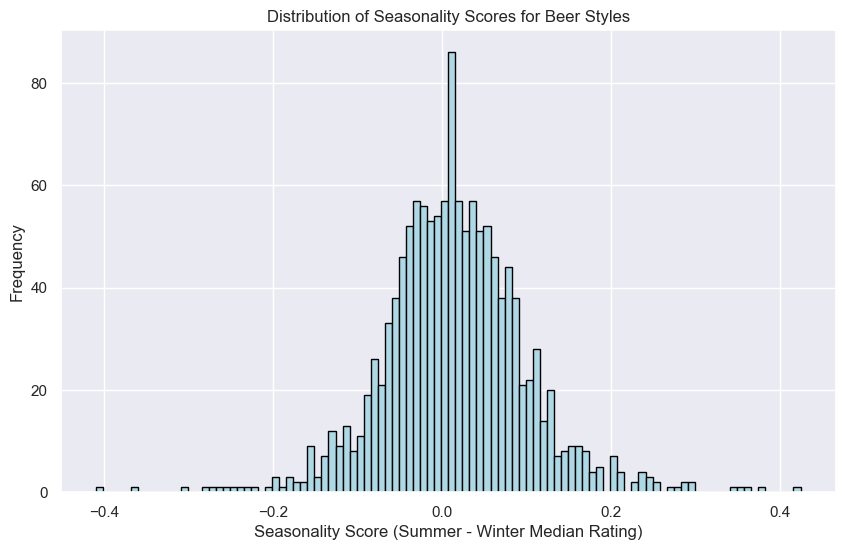

In [ ]:
seasonality_scores = helper.calculate_seasonality_score_by_style(df_reviews, min_reviews=100)

plt.figure(figsize=(10, 6))
plt.hist(seasonality_scores['Seasonality_Score'], bins=100, color='lightblue', edgecolor='black')
plt.xlabel('Seasonality Score (Summer - Winter Median Rating)')
plt.ylabel('Frequency')
plt.title('Distribution of Seasonality Scores for Beer Styles')
plt.show()

#### Test if Data is Normally Distributed

After calculating the seasonality score for our dataset, we performed a **Shapiro-Wilk Test** to test for normality. The resulting p-value was extremely small (6.3e-16), which is far below the typical significance level of 0.05. This indicates that we **reject the null hypothesis (H₀)**, meaning that the data does **not** follow a normal distribution.

However, since we have a sample size of **1278**, we can invoke the **Central Limit Theorem (CLT)**. The CLT states that for sufficiently large sample sizes, the distribution of the sample mean will approximate a normal distribution, regardless of the underlying distribution of the data. Given the large sample size, we can reasonably assume that the sample mean will be normally distributed, allowing us to proceed with statistical analysis that assumes normality.

In [ ]:
stat, p_value = stats.shapiro(seasonality_scores['Seasonality_Score'])
print(f"Shapiro-Wilk Test: p-value = {p_value}")

if p_value > 0.05:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

Shapiro-Wilk Test: p-value = 7.521329216201117e-15
Data does not look normally distributed (reject H0)


In [ ]:
len(seasonality_scores['Seasonality_Score'])

1315

#### Determine if the Mean is Significantly Different from Zero
The mean seasonality score is slightly positive, indicating higher beer ratings in summer compared to winter, while the median is close to the mean, suggesting a relatively symmetric distribution. The skewness of 0.402 indicates a mild positive skew, meaning a few higher values are pulling the distribution to the right.

A one-sample t-test was conducted to test if the mean seasonality score is significantly different from zero. The results showed a very low p-value, allowing us to reject the null hypothesis and conclude that the mean seasonality score is significantly different from zero. This confirms that, on average, beer ratings in summer are higher than in winter.

In [21]:
mean_score = seasonality_scores['Seasonality_Score'].mean()
median_score = seasonality_scores['Seasonality_Score'].median()
skewness_score = stats.skew(seasonality_scores['Seasonality_Score'].dropna())

print("Mean Seasonality Score:", mean_score)
print("Median Seasonality Score:", median_score)
print("Skewness of Seasonality Score:", skewness_score)

Mean Seasonality Score: 0.014627834110268028
Median Seasonality Score: 0.011753803379622951
Skewness of Seasonality Score: 0.16434158695981183


In [ ]:
t_stat, p_value = stats.ttest_1samp(seasonality_scores['Seasonality_Score'], 0)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: The mean seasonality score is significantly different from zero.")
else:
    print("Fail to reject the null hypothesis: The mean seasonality score is not significantly different from zero.")

T-statistic: 6.323685261196697
P-value: 3.4927665236397137e-10
Reject the null hypothesis: The mean seasonality score is significantly different from zero.


## 4.2. <a id='toc4_2_'></a>[Seasonality in the Number of Ratings for different Beer Styles](#toc0_)
We defined the Number of Ratings of a beer style as the count of ratings it recieved n a given months.

To examine seasonal trends, we analyzed the top 10 most frequently rated beer styles each month, identifying those that appeared only during specific periods and those that remained consistently in the top ranks.  

As shown in the plot "Top 10 Beer Styles by Number of Reviews per Month (Grouped by Season)" below, certain beer styles appear only during specific periods, such as Pumpkin Ale in the fall, Fruit and Vegetable beers in late spring and summer, Märzen/Oktoberfest beers in September and October, and Winter Warmer in December.  

Other beer styles appear to maintain consistent popularity throughout the year. American IPA is the most rated beer type each month, with American Double/Imperial IPA consistently in second place. Saison/Farmhouse Ale tends to occupy a middle position, while American Amber/Red Ale often ranks near the bottom of the set.  

In [ ]:
# Load data
df_reviews = pd.read_csv('src/data/beerAdvocateReviewsUSA.csv')

In [12]:
top_styles_per_month_percentage = helper.top_k_beer_styles_percentage(df = df, k = 10, group_by = 'month')
top_styles_per_month_percentage.head()

,month,style,rating_count,total_ratings,percentage
0,1,American IPA,18626,207442,8.978895
1,1,American Double / Imperial IPA,14424,207442,6.953269
2,1,American Double / Imperial Stout,11698,207442,5.639167
3,1,Russian Imperial Stout,8186,207442,3.946163
4,1,American Pale Ale (APA),7838,207442,3.778406


In the plot below, we can observe the top 10 beer styles the most frequently reviewed for each month, as the percentage of the total ratings of that specific month. 

We can observe that certain beer styles appear only during specific periods, such as Pumpkin Ale in the fall, Fruit and Vegetable beers in late spring and summer, Märzen/Oktoberfest beers in September and October, and Winter Warmer in December.   

Other beer styles appear to maintain numbers of ratings throughout the year. American IPA is the most rated beer type each month, with American Double/Imperial IPA consistently in second place. Saison/Farmhouse Ale tends to occupy a middle position, while American Amber/Red Ale often ranks near the bottom of the set.  

In [13]:
top_styles_per_month_percentage_sorted = top_styles_per_month_percentage.sort_values(by=['month', 'percentage'], ascending=[True, False])

unique_styles = top_styles_per_month_percentage['style'].unique()
palette = sns.color_palette("tab20", len(unique_styles)).as_hex()
style_colors = dict(zip(unique_styles, palette))

# Uncomment the category_orders dictionary
category_orders = {
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    #'style': top_styles_list
}

frames = [go.Frame(
    data=[go.Bar(
        x=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == month]['percentage'],
        y=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == month]['style'],
        orientation='h',
        marker_color=[style_colors[x] for x in top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == month]['style'].to_list()],
    )],
    name=str(month),
) for month in category_orders['month']]

fig = go.Figure(
    data=[go.Bar(
        x=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == 1]['percentage'],
        y=top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == 1]['style'],
        orientation='h',
        marker_color=[style_colors[x] for x in top_styles_per_month_percentage_sorted[top_styles_per_month_percentage_sorted['month'] == 1]['style'].to_list()],
    )],
    layout=go.Layout(
        title="Top Beer Styles by Percentage of Reviews per Month",
        xaxis=dict(title="Percentage of Ratings"),
        yaxis=dict(title="Beer Style", automargin=True),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=1, redraw=True), fromcurrent=True)])],
            x=1.15,  # Position the button on the top right
            xanchor='right',
            y=1.15,
            yanchor='top'
        )],
        sliders=[{
            'steps': [
                {'args': [
                    [str(month)],
                    {'frame': {'duration': 1, 'redraw': True}, 'mode': 'immediate'}
                ],
                'label': str(month),
                'method': 'animate'} for month in category_orders['month']
            ],
            'transition': {'duration': 1},
            'x': 0.1,
            'len': 0.9,
            'currentvalue': {
                'prefix': 'month: ',
                'font': {'size': 20, 'color': '#666'}
            }
        }]
    ),
    frames=frames
)
fig.show()
fig.write_html("illustrations/Jeanne/top_styles_per_month_percentage.html")

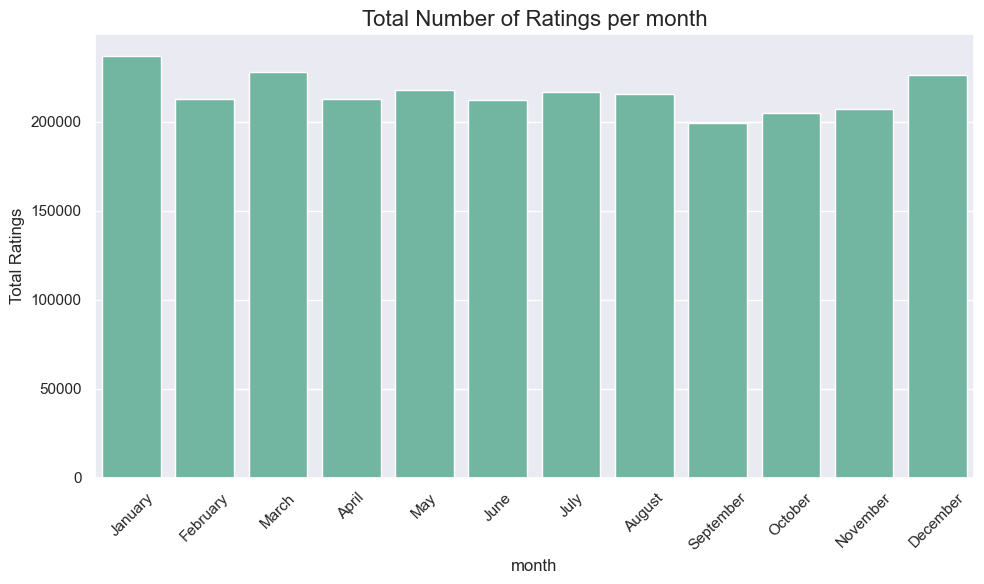

In [ ]:
total_ratings_per_month = reviews_df.groupby('month').size().reset_index(name='rating_count')

total_ratings_per_month = total_ratings_per_month.sort_values(by='month')

plt.figure(figsize=(10, 6))
sns.barplot(data=total_ratings_per_month, x='month', y='rating_count')

plt.title('Total Number of Ratings per month', fontsize=16)
plt.xlabel('month', fontsize=12)
plt.ylabel('Total Ratings', fontsize=12)
plt.xticks(ticks=range(12), labels=[pd.to_datetime(f'2023-{month:02d}-01').strftime('%B') for month in range(1, 13)], rotation=45)
plt.tight_layout()
plt.show()


## 4.3. <a id='toc4_3_'></a>[Average Rating vs. Number of Ratings of Selected Beer Styles](#toc0_)

We chose the following beer styles for analysis based on their patterns of Numbers of Ratings:

- **Seasonal Beers**: **Fruit/Vegetable Beer**, **Pumpkin Ale**, and **Winter Warmer** are considered seasonal because they are popular only during specific periods of the year.
- **Unseasonal Beers**: **American IPA**, **Saison/Farmhouse Ale**, and **American Amber/Red Ale** are considered unseasonal, as they maintain consistent popularity throughout the year.

For each of these beer types, we computed the following metrics:
- **Number of Ratings per Month** for both seasonal and unseasonal beers.
- **Percentage of Ratings per Month** for each style within its category.
- **Average Rating per Month** for the selected beer styles.

This analysis revealed some interesting patterns that warrant further investigation. For example, we could refine the analysis by identifying a subset of beers with high seasonality and excluding beers with high popularity and large deviations from the average rating. These **impactful beers**, which have high popularity during specific periods and significant variability in their ratings, may offer deeper insights into the dynamics of seasonal trends.


In [30]:
# Chose the beer styles with interessant features
beer_styles = [
    'Fruit / Vegetable Beer', 'Pumpkin Ale', 'Winter Warmer',  # Seasonal beers
    'American IPA', 'Saison / Farmhouse Ale', 'American Amber / Red Ale'  # Unseasonal beers
]

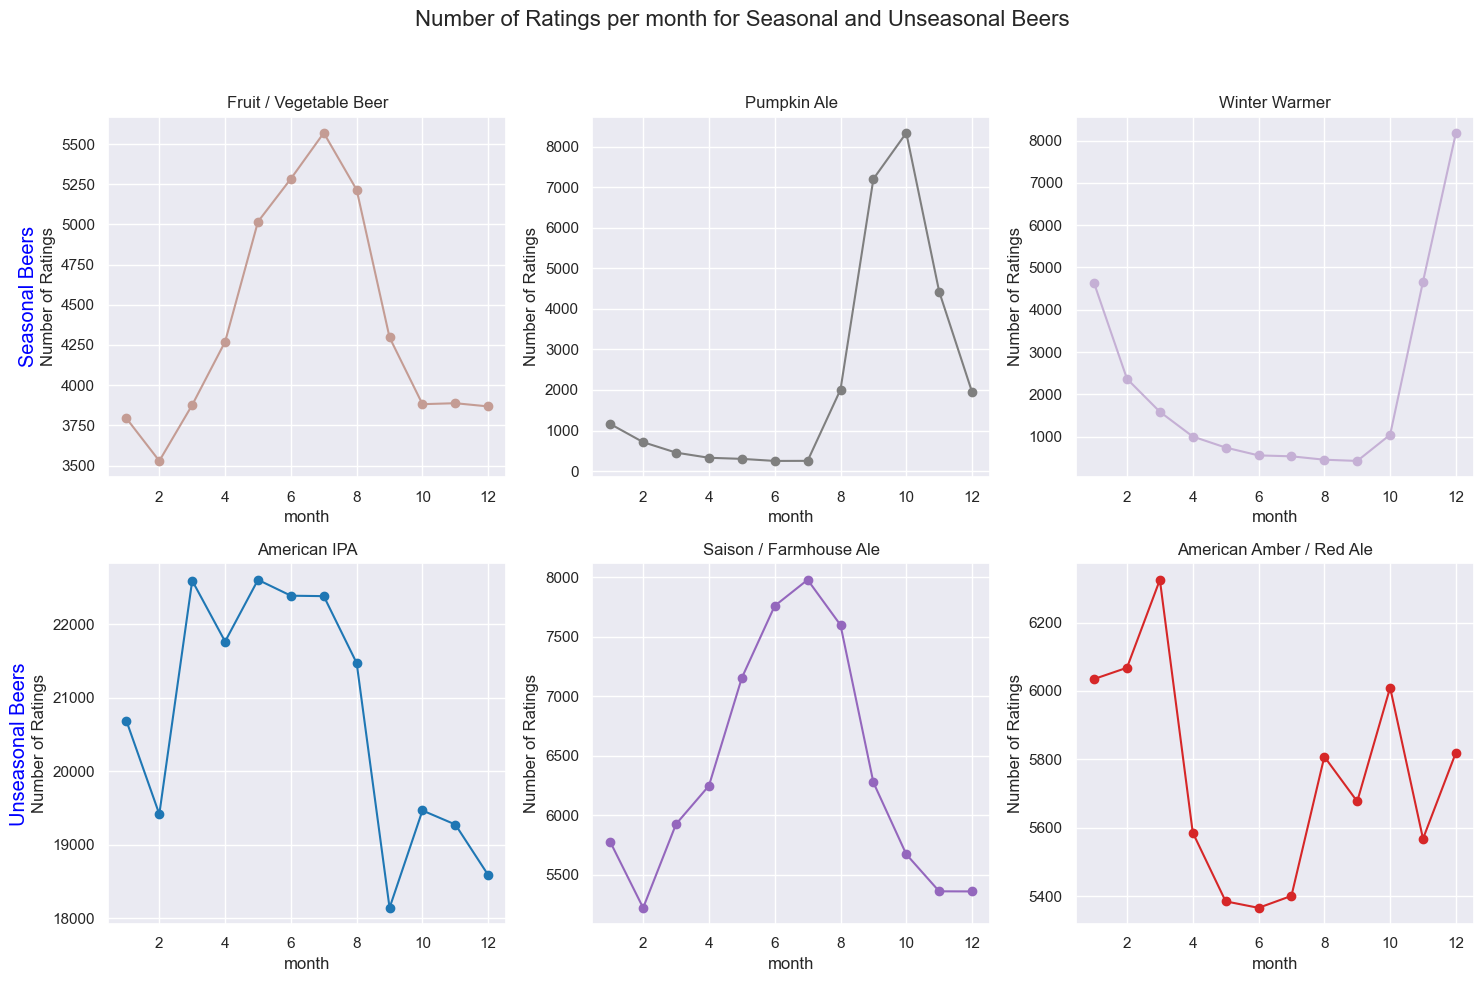

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Number of Ratings per month for Seasonal and Unseasonal Beers', fontsize=16)

categories = ['Seasonal Beers', 'Unseasonal Beers']

# Loop over each beer style and corresponding subplot for the number of ratings
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    # Filter DataFrame for the current style
    style_df = reviews_df[reviews_df['style'] == style]
    
    # Group by month and count the number of ratings
    monthly_counts = style_df.groupby('month').size()
    
    # Plot the monthly counts on the current subplot
    ax.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color=style_colors[style])
    ax.set_title(style)
    ax.set_xlabel('month')
    ax.set_ylabel('Number of Ratings')
    
    # Add the category label on the left of each row
    if idx % 3 == 0:  # Only add the label on the first column of each row
        row_label = categories[idx // 3]
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90, color='blue')
        
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

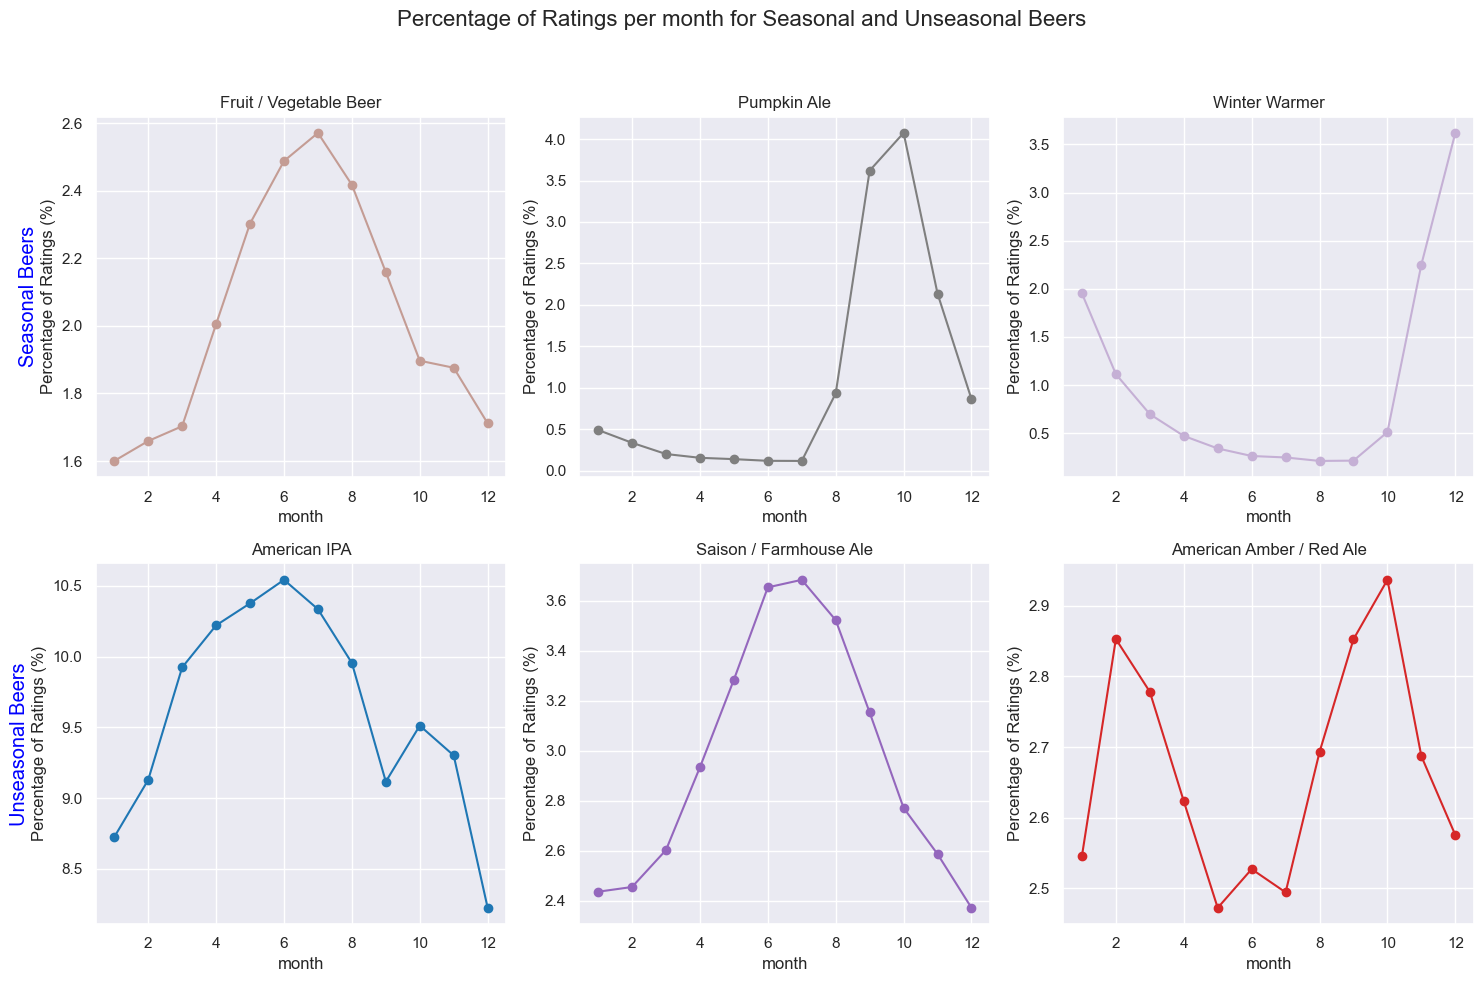

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Percentage of Ratings per month for Seasonal and Unseasonal Beers', fontsize=16)

# Loop over each beer style and corresponding subplot for percentage of ratings
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    style_df = reviews_df[reviews_df['style'] == style] 
    
    monthly_counts = style_df.groupby('month').size() # Count number of ratings per month
    
    # Calculate percentage of total ratings per month
    total_monthly_ratings = reviews_df.groupby('month').size()
    monthly_percentages = (monthly_counts / total_monthly_ratings) * 100
    
    # Plot the monthly percentages on the current subplot
    ax.plot(monthly_percentages.index, monthly_percentages.values, marker='o', linestyle='-', color=style_colors[style])
    ax.set_title(style)
    ax.set_xlabel('month')
    ax.set_ylabel('Percentage of Ratings (%)')
    
    # Add the category label on the left of each row
    if idx % 3 == 0:  # Only add the label on the first column of each row
        row_label = categories[idx // 3]
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='center', va='center', rotation=90, color='blue')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

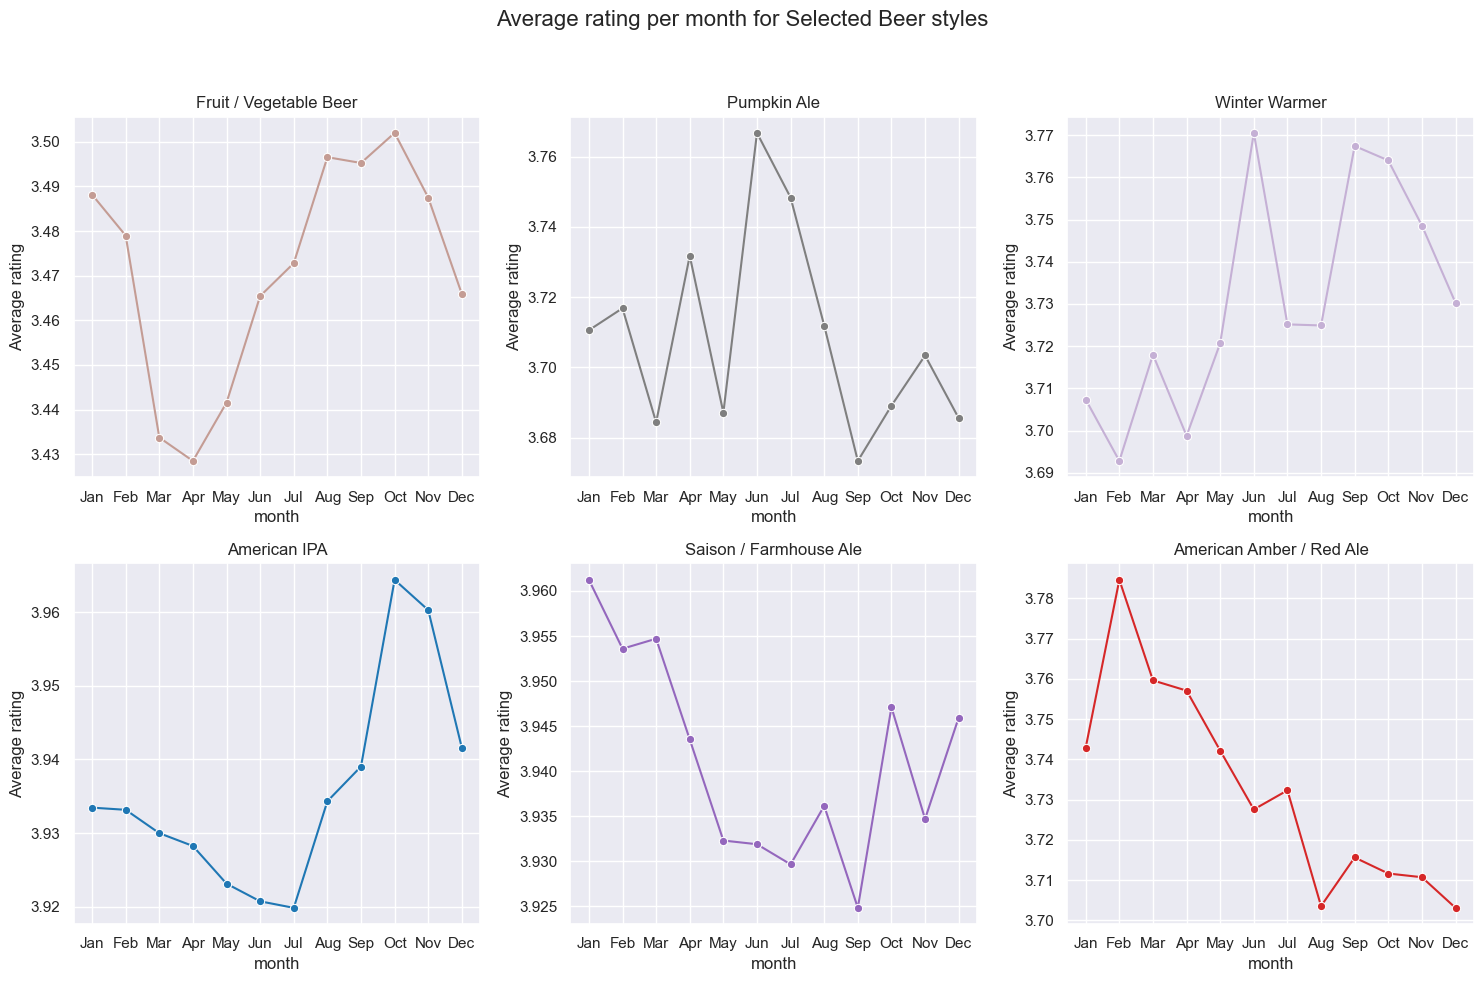

In [ ]:
# Filter the dataset for the selected beer styles
df_filtered = reviews_df[reviews_df['style'].isin(beer_styles)]

# Group by month and style, then calculate the average rating per group
monthly_ratings = df_filtered.groupby(['month', 'style'])['rating'].mean().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loop over each beer style and corresponding subplot
for idx, (ax, style) in enumerate(zip(axes.flatten(), beer_styles)):
    
    # Get data only for current subplot and plot monthly average rating
    style_df = monthly_ratings[monthly_ratings['style'] == style]
    sns.lineplot(data=style_df, x='month', y='rating', marker='o', ax=ax, color=style_colors[style])
    
    # Subplot titles
    ax.set_title(style, fontsize=12)
    ax.set_xlabel('month')
    ax.set_ylabel('Average rating')
    ax.set_xticks(range(1, 13))  # Set x-axis ticks for months
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

fig.suptitle('Average rating per month for Selected Beer styles', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


**ANALYSIS BASED ON METRICS TO BE DONE!*

### Degree of seasonality depending on latitude

We initially considered exploring the degree of seasonality depending on latitude to understand how variations in weather conditions, influenced by geographical location, might affect beer ratings. The basic idea was that regions further from the equator experience more pronounced seasonal changes, which could potentially impact local beer preferences and ratings. However, after reviewing the literature, we found that defining a "degree of seasonality" solely based on latitude is overly simplistic and not widely established in existing studies.  

In a relevant study (https://academic.oup.com/icb/article/57/5/934/3896236), it was highlighted that seasonality is influenced by factors beyond latitude, such as the Earth's axial tilt, which causes different regions at the same latitude to experience varying degrees of seasonality. Factors like day length and temperature, which are not directly linked to latitude, also play a crucial role in determining seasonal changes. While weather data could provide insights into these variables, we would still face challenges in combining them into a comprehensive metric for seasonality.  

Given these complexities and the lack of a well-defined measure in the literature, we decided to abandon the idea of creating a latitude-based seasonality metric, as it would have required arbitrary assumptions and lacked a clear, scientifically grounded foundation.  

# 5. <a id='toc5_'></a>[3 Weather Influence by State](#toc0_)

## 5.1. <a id='toc5_1_'></a>[climatezone per country / state](#toc0_)

### US States

- decide on a states climatezone based on the counties climatezones and weighted by population. In other words: in what climate zones do people in that state live We do this to anaylze in what conditions beer-reviewers live.
County climatezone data from US department for energy: https://www.energy.gov/sites/prod/files/2015/10/f27/ba_climate_region_guide_7.3.pdf
- county population data from: https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html
- used formatted table from github: https://gist.github.com/philngo/d3e251040569dba67942#file-climate_zones-csv
- state abbreviation list:https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html


In [ ]:
# Define paths
countiesClimate_df_path = "data/climatezones/climate_zones.csv"
countiesPopulation_df_path = "data/climatezones/countyPopulation.xlsx"

# Get the climate data with population
climate_data_with_population = WaH.add_population_to_climate_data(countiesClimate_df_path, countiesPopulation_df_path)

# Get the most populated climate zone for each state
most_populated_climate_zone = WaH.get_most_populated_climate_zone(climate_data_with_population)

# View the result
most_populated_climate_zone.head()


/Users/klusertim/EPFL/ada-2024-project-leonardodatavinci/src/utils/USClimateAndWeatherHelper.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  match = countiesPopulation_df[countiesPopulation_df['County'].str.contains(row['County'], case=False, na=False)]


,State,IECC Climate Zone,Population
0,AK,7,555076.0
3,AL,3,4377717.0
4,AR,3,3483542.0
6,AS,1,0.0
7,AZ,2,6116085.0


## 5.2. <a id='toc5_2_'></a>[Extracting weather data from excel files](#toc0_)

In [5]:
precipitation_df = WaH.extract_data_from_excel('data/weather-data/cru-x0.5_timeseries_pr_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')
temperature_df = WaH.extract_data_from_excel('data/weather-data/cru-x0.5_timeseries_tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')

#export to csv
precipitation_df.to_csv('data/weather-data/us-precipitations.csv', index=False)
temperature_df.to_csv('data/weather-data/us-temperatures.csv', index=False)

precipitation_df

,code,state,value,year,month
0,USA,United States of America,46.10,1901,1
1,USA.2593214,Alabama,116.85,1901,1
2,USA.2593215,Alaska,35.22,1901,1
3,USA.2593216,Arizona,24.17,1901,1
4,USA.2593217,Arkansas,60.62,1901,1
...,...,...,...,...,...
76123,USA.2593260,Virginia,96.01,2022,12
76124,USA.2593261,Washington,169.15,2022,12
76125,USA.2593262,West Virginia,82.01,2022,12
76126,USA.2593263,Wisconsin,50.55,2022,12


In [6]:
# Compute oldest and newest year
oldest_year = min(precipitation_df['year'].min(), temperature_df['year'].min())
newest_year = max(precipitation_df['year'].max(), temperature_df['year'].max())

# Print the oldest and newest year
print(f"Oldest year: {oldest_year}")
print(f"Newest year: {newest_year}")


Oldest year: 1901
Newest year: 2022


In [7]:
month = 1
year = 1986
state = "United States of America"

precipitation_USA_1986_1 = WaH.value_from_date_and_state(precipitation_df, year, month, state)
print(f"Precipitation in {state} in {month}-{year}: {precipitation_USA_1986_1}")

Precipitation in United States of America in 1-1986: 36.83


In [10]:
beer_data = reviews_df 

In [ ]:
# Filter for US only
beer_data_with_weather = beer_data[beer_data["country_name"] == "United States"]

#Filter for years between 2002 and 2017
beer_data_with_weather = beer_data_with_weather[(beer_data_with_weather["year"] >= 2002) & (beer_data_with_weather["year"] <= 2017)]

# print shape
print("original shape: ", beer_data.shape)
print("new shape: ", beer_data_with_weather.shape)

# beer_data_with_weather = beer_data_with_weather.head(1000)

beer_data_with_weather = WaH.apply_value_from_date_and_state(beer_data_with_weather,precipitation_df, "Precipitation")
beer_data_with_weather = WaH.apply_value_from_date_and_state(beer_data_with_weather,temperature_df, "Temperature")
beer_data_with_weather = preProcessingHelper.merge_with_states(beer_data_with_weather)


beer_data_with_weather

original shape:  (2240430, 13)
new shape:  (2239823, 13)


,rating,appearance,aroma,palate,taste,overall,country_name,country_code3,state,date_object,month,year,style,Precipitation,Temperature,abbreviation
0,2.88,3.25,2.75,3.25,2.75,3.00,United States,USA,Washington,2015-08-20 12:00:00,8,2015,Euro Pale Lager,40.63,19.08,WA
1,3.67,3.00,3.50,3.50,4.00,3.50,United States,USA,New York,2009-02-20 12:00:00,2,2009,English Pale Ale,43.11,-4.40,NY
2,3.91,4.25,4.50,3.25,3.75,3.75,United States,USA,North Carolina,2013-02-13 12:00:00,2,2013,English Pale Ale,108.89,5.84,NC
3,3.64,4.00,3.75,3.50,3.50,3.75,United States,USA,New York,2013-01-09 12:00:00,1,2013,English Pale Ale,56.13,-4.27,NY
4,2.77,3.00,3.50,2.50,2.50,2.50,United States,USA,Illinois,2012-11-17 12:00:00,11,2012,English Pale Ale,29.50,5.59,IL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239818,3.18,3.50,3.00,3.50,3.00,3.50,United States,USA,Rhode Island,2004-11-15 12:00:00,11,2004,American Pale Ale (APA),108.62,6.62,RI
2239819,3.80,3.50,3.50,3.50,4.00,4.00,United States,USA,Connecticut,2006-02-27 12:00:00,2,2006,Kölsch,54.93,-1.24,CT
2239820,2.80,3.00,3.00,3.00,2.50,3.00,United States,USA,Maryland,2006-02-19 12:00:00,2,2006,Kölsch,41.60,2.06,MD
2239821,1.54,3.00,1.50,1.00,1.50,1.50,United States,USA,Virginia,2004-08-10 12:00:00,8,2004,Kölsch,121.49,22.24,VA


## 5.3. <a id='toc5_3_'></a>[Data Analysis](#toc0_)

In [ ]:
# Create a 'date' column for easier grouping
beer_data_with_weather['date'] = pd.to_datetime(beer_data_with_weather[['year', 'month']].assign(day=1))

# 1. Plot month/year vs. number of rows using Plotly

# Count the number of rows per unique date
row_counts = beer_data_with_weather['date'].value_counts().sort_index()

# Create a line plot using Plotly Express
fig = px.line(
    x=row_counts.index,
    y=row_counts.values,
    labels={'x': 'Date', 'y': 'Number of Rows'},
    title='Number of Rows per Month/Year'
)

# Update layout for better appearance
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',
        tickangle=45
    ),
    xaxis_tickformatstops=[
        dict(dtickrange=[None, None], value="%Y-%m")
    ]
)

#Save the plot
fig.write_html("illustrations/Nicolas/number_of_rows_per_month_year.html")

# 2. Plot a timeline with start month/year and end month/year using Plotly

# Get the start and end dates
start_date = beer_data_with_weather['date'].min()
end_date = beer_data_with_weather['date'].max()

# Create a figure
fig_timeline = go.Figure()

# Add a line and markers to represent the timeline
fig_timeline.add_trace(go.Scatter(
    x=[start_date, end_date],
    y=[0, 0],
    mode='lines+markers',
    marker=dict(size=10),
    line=dict(width=2),
    showlegend=False
))

# Update layout for the timeline
fig_timeline.update_layout(
    title=f'Timeline of Dataset<br><sup>Start: {start_date.strftime("%Y-%m")} | End: {end_date.strftime("%Y-%m")}</sup>',
    xaxis_title='Date',
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    xaxis=dict(
        tickformat='%Y-%m',
        tickangle=45
    ),
    height=200,
    margin=dict(l=50, r=50, t=80, b=50)
)


#Save the plot
fig_timeline.write_html("illustrations/Nicolas/timeline.html")

In [ ]:
# Average temperature per month for each state
avg_temp_state = beer_data_with_weather.groupby(['state', 'month'])['Temperature'].mean().reset_index()

# Plot
fig = px.line(avg_temp_state, x='month', y='Temperature', color='state', 
              title="Average Monthly Temperature by State",
              labels={'Temperature': 'Avg Temperature (°C)', 'month': 'Month', 'state': 'State'})
fig.update_layout(xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

#save
fig.write_html("illustrations/Nicolas/avg_temp_state.html")


In [ ]:
# Calculate average temperature by state and month
temp_heatmap = beer_data_with_weather.groupby(['state', 'month'])['Temperature'].mean().reset_index()

# Create heatmap with inverted axes (months on y-axis, states on x-axis)
fig = px.imshow(temp_heatmap.pivot(index='month', columns='state', values='Temperature'),
                labels=dict(x="State", y="Month", color="Avg Temperature (°C)"),
                y=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                title="Average Temperature by Month and State")


# Save plot
fig.write_html("illustrations/Nicolas/heatmap.html")

In [15]:
# Calculate the average temperature by state abbreviation
state_avg_temp = beer_data_with_weather.groupby('abbreviation')['Temperature'].mean().reset_index()

state_avg_temp = preProcessingHelper.merge_with_abbreviations(state_avg_temp)

state_avg_temp.head()

,abbreviation,Temperature,state
0,AK,-5.983656,Alaska
1,AL,17.964573,Alabama
2,AR,16.657295,Arkansas
3,AZ,15.891391,Arizona
4,CA,14.428512,California


In [ ]:
# Create the choropleth map
fig = px.choropleth(
    state_avg_temp,
    locations='abbreviation',  # Column with state abbreviations
    locationmode='USA-states',  # Specifies that locations are USA states
    color='Temperature',  # Data to color the states by
    scope='usa',  # Focuses the map on the USA
    color_continuous_scale='Viridis',  # Color scale
    labels={'Temperature': 'Avg Temperature (°C)','state':'State'},
    title='Average Temperature by State in the USA',
    hover_data={'state': True}           # Adds state name to hover information
)

# Save 
fig.write_html("illustrations/Nicolas/temperature.html")


In [16]:
# Calculate the average temperature by state abbreviation
state_monthly_avg_temp = beer_data_with_weather.groupby(['abbreviation', 'month'])['Temperature'].mean().reset_index()

state_monthly_avg_temp = preProcessingHelper.merge_with_abbreviations(state_monthly_avg_temp)

state_monthly_avg_temp.head()

,abbreviation,month,Temperature,state
0,AK,1,-17.886830,Alaska
1,AK,2,-15.535399,Alaska
2,AK,3,-12.840988,Alaska
3,AK,4,-4.540952,Alaska
4,AK,5,3.844366,Alaska


In [ ]:
# Define fixed color scale range
min_temp = state_monthly_avg_temp['Temperature'].min()  # e.g., -35
max_temp = state_monthly_avg_temp['Temperature'].max()  # e.g., 30

# Create the timelapse choropleth map
fig = px.choropleth(
    state_monthly_avg_temp,
    locations='abbreviation',           # Column with state abbreviations
    locationmode='USA-states',           # Specifies that locations are USA states
    color='Temperature',                 # Data to color the states by
    hover_name='state',                  # Display full state name on hover
    scope='usa',                         # Focuses the map on the USA
    color_continuous_scale='Viridis',    # Color scale
    labels={'Temperature': 'Avg Temperature (°C)', 'month': 'Month'},
    title='Average Temperature by State in the USA Over Time',
    animation_frame='month',             # Create animation based on the month
    range_color=[min_temp, max_temp]     # Set fixed scale for the color range
)

# Customize animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500  # Adjust speed (milliseconds per frame)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 300

# Save Timelapse
fig.write_html("illustrations/Nicolas/timelapse_temperature.html")


## 5.4. <a id='toc5_4_'></a>[Archive - World Climate Zones](#toc0_)

In [ ]:
from src.utils.climateZoneLoaderWorldwide import generate_climate_map, get_climate_class, generate_station_map, load_station_data

In [ ]:
# Define period and file path
period = '1986-2010'
raster_file = f'data/climatezones/Map_KG-Global/KG_{period}.grd'

In [ ]:
# Example usage:
generate_climate_map(raster_file, 10)
print(get_climate_class(16.375, 48.210, raster_file))  # Example: Vienna, Austria

In [ ]:
# Load the data and generate the map
df = load_station_data('data/climatezones/weather_stations_world.txt')
generate_station_map(df)

In [ ]:
# Define the column specifications: (start position, end position)
colspecs = [
    (0, 7),    # Wmo#
    (8, 9),    # R
    (10, 15),   # Lat
    (16, 22),  # Lon
    (23, 47),  # Country Name
    (48, 73),  # Station Name
    (74, 78),  # Statn Elev (m)
    (79, 85),  # Barom Elev (.1m)
    (86, 96),  # Local Statn #
    (97, 99),  # Separator
    (100, 105),  # Mean Stn Pres
    (106, 110), # Mean Slvl Pres
    (111, 115),# Mean Temp
    (116, 120),# Dly Totl Prec
    (121, 125),# Mean Max Temp
    (126, 130),# Mean Min Temp
    (131, 135),# Mean RH
    (136, 141) # Total # Obs
]

# Define the column names
column_names = [
    'Wmo#', 'R', 'Lat', 'Lon', 'Country Name', 'Station Name',
    'Statn Elev (m)', 'Barom Elev (.1m)', 'Local Statn #', 'Separator',
    'Mean Stn Pres', 'Mean Slvl Pres', 'Mean Dly Temp', 'Totl Prec',
    'Mean Max Temp', 'Mean Min Temp', 'Mean RH', 'Total # Obs'
]

# Read the data using read_fwf
df = pd.read_fwf(
    'data/climatezones/weather_stations_world.txt',
    colspecs=colspecs,
    skiprows=4,  # Skip header rows
    names=column_names,
    encoding='ISO-8859-1'  # Specify encoding to handle special characters
)

# Display the first few rows of the DataFrame
print(df.head(6))


# Conclusion

In this data analyais we started wih.....